<a href="https://colab.research.google.com/github/EkaterinaVoloshina/NNMethods/blob/main/NN_HW3_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from string import punctuation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
from torchmetrics.functional import f1, recall, accuracy
import torch.optim as optim
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/Fake.csv')

In [4]:
df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Посмотрим, как устроен датасет:

In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


Будем предсказывать по тексту новости ее тему (то есть subject).

### Анализ данных

Посмотрим, есть ли в данных пропуски и дубли:

In [6]:
print('Дублей нет.') if df.duplicated().any() == False else print('Есть дубли.')
print('Нет пропущенных значений.') if df.count().min() == df.shape[0] else print('Есть пропущенные значения.')
print('Нет NaNs.') if df.isnull().values.any() == False else print('Есть NaNs.')

Есть дубли.
Нет пропущенных значений.
Нет NaNs.


In [7]:
df = df.drop_duplicates()

Теперь посмотрим, написаны ли они все латиницей:

In [8]:
print('Уникальные символы:', ''.join(set(' '.join(df['text'].tolist()))))

Уникальные символы: ;*)#uokl\/2+wI1Yc$hZKzUJ5!.&xg`f<[8-"aT,4H@F?G>|{]jqQBdDS p%iL0bX7(te9PN_~}vA3m=RsyO^VWMEn':6Cr


Как мы видим, все написано латиницей, поэтому воспользуемся стандартной предобработкой в виде токенизации и отчищения от пунктуации.

### Предобработка

In [9]:
from nltk import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

In [10]:
def tokenize(text):
    tokens = tokenizer.tokenize(text.lower())
    tokens = [token for token in tokens if token not in punctuation]
    return tokens

In [11]:
df['tokens'] = df['text'].apply(tokenize)

Посмотрим, какой длины наши тексты. Это понадобится для паддинга:

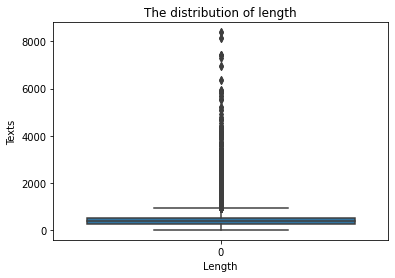

In [12]:
sns.boxplot(data=df['tokens'].str.len())
plt.xlabel('Length')
plt.ylabel('Texts')
plt.title('The distribution of length')
plt.show()

In [13]:
df['length'] = df['text'].apply(len)

Возьмем только тексты:

In [14]:
df = df[df['length'] != 0]

Теперь составим словарь всех токенов:

In [15]:
vocab = ['<UNK>'] + list(set([word for sentence in df['tokens'] for word in sentence]))
word2id = {c:i for i, c in enumerate(vocab)}

Теперь найдем слова в эмбеддингах Word2Vec. Они понадобятся нам дальше для инициализации модели, как в статье. Как и в статье, возьмем эмбеддинги гугла

In [16]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')
weights = np.zeros((len(word2id), 300))
count = 0
for word, i in word2id.items():
    if word == '<UNK>':
        continue   
    try:
        weights[i] = wv.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,300)
np.save('weights.npy', weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


In [17]:
#weights = np.load('/content/gdrive/MyDrive/weights.npy')

Посмотрим, какие классы у нас есть, и закодируем их с помощью LabelEncoder.

In [18]:
print('Классы:', '/'.join(df['subject'].unique()))

Классы: News/politics/Government News/left-news/US_News/Middle-east


Как мы видим, классов 6.

In [19]:
encoder = LabelEncoder()

Как и в статье, будем экспериментировать на подвыборке данных:

In [20]:
df = df.sample(5000) 

In [21]:
target = encoder.fit_transform(df['subject'])
X_train, X_test, y_train, y_test = train_test_split(df, target)

In [22]:
DEVICE = 'cuda:0'

В статье авторы паддили до самого длинного текста в обучающей выборке. Посмотрим, какой текст самый длинный в нашей выборке:

In [23]:
MAXLEN = max(X_train['length'])
print(MAXLEN)

46960


Как видно из графика выше, таких текстов мало, поэтому мы обрежем по 1000 (по графику)

In [24]:
MAXLEN = 1000

### Модель

Теперь сделаем датасет с паддингом, как в статье (но до другой длины)

In [25]:
class NewsDataset(Dataset):
    def __init__(self, df, target, device, maxlen, word2id):
        self.dataset = df
        self.target = target
        self.device = device
        self.maxlen = MAXLEN
        self.word2id = word2id
        self.vocab_size = len(self.word2id.keys())
        self.id2word = {i:c for c, i in word2id.items()}
    
    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.dataset[index]  # токенизируем
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        ids = F.pad(ids, (0, self.maxlen-len(ids)))
        y = self.target[index]
        return ids, y
    
    def __len__(self):
        return len(self.target)

In [26]:
train_dataset = NewsDataset(X_train['tokens'].values, y_train, DEVICE, MAXLEN, word2id)
train_iterator = DataLoader(train_dataset, shuffle=True, batch_size=64)
val_dataset = NewsDataset(X_test['tokens'].values, y_test, DEVICE, MAXLEN, word2id)
val_iterator = DataLoader(val_dataset, shuffle=True, batch_size=64)

Построим модель, которая была описана в статье:

In [27]:
class CLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, filter_number, 
                  filter_size, hidden_size, num_layers, dropout=None, 
                 dropout_per=0, weights=None):
      super().__init__()
      self.vocab_size = vocab_size
      self.embedding_dim = embedding_dim
      self.filter_number = filter_number
      self.filter_size = filter_size
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.conv_layers = len(filter_size)
      self.dropout_param = dropout
        
      self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
      if type(weights) == np.ndarray:
            self.embedding.from_pretrained(torch.tensor(weights))
      self.conv = []
      self.conv2 = nn.Conv1d(in_channels=self.embedding_dim, 
                              out_channels=self.filter_number, 
                              kernel_size=2,
                              padding='valid')
      self.conv3 = nn.Conv1d(in_channels=self.embedding_dim, 
                              out_channels=self.filter_number, 
                              kernel_size=3,
                              padding='valid')
      self.conv3 = nn.Conv1d(in_channels=self.embedding_dim, 
                              out_channels=self.filter_number, 
                              kernel_size=4,
                              padding='valid')
      self.relu = nn.ReLU()
      self.lstm = nn.LSTM(
            input_size=(self.filter_number*self.conv_layers),
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
      )
      self.linear = nn.Linear(self.hidden_size, 6)
      self.dropout = nn.Dropout(p=dropout_per)

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        if self.dropout_param == 'before':
            embedded = self.dropout(embedded)
        conv_layers = []
        if 2 in self.filter_size:
            conv_layers.append(self.relu(self.conv2(embedded)).transpose(1,2))
        if 3 in self.filter_size:
            conv_layers.append(self.relu(self.conv2(embedded)).transpose(1,2))
        if 4 in self.filter_size:
            conv_layers.append(self.relu(self.conv2(embedded)).transpose(1,2))
        for i, layer in enumerate(conv_layers):
            if i == 0:
              length = layer.shape[1]
              conv_layer = layer
            else:
              conv_layer = torch.cat((conv_layer, layer[:,:length,:]), 2)
        lstm_out, (ht, ct) = self.lstm(conv_layer)
        lstm_layer = ht[-1]
        if self.dropout_param == 'after':
            logits = self.dropout(lstm_layer) 
        logits = self.linear(lstm_layer)
        return logits

Функция обучения:

In [28]:
def train(model, iterator, optimizer, criterion, metric, device):
    print('Training...')
    epoch_loss = 0 
    epoch_metric = 0
    model.train()  

    for i, (texts, ys) in enumerate(iterator): 
        optimizer.zero_grad()
        texts = texts.to(device)
        ys = ys.to(device)
        preds = model(texts.squeeze())  
        loss = criterion(preds, ys.long())   
        loss.backward() 
        optimizer.step()
        epoch_loss += loss.item() 
        
        batch_metric = metric(preds, ys.long(), ignore_index=0)
        epoch_metric += batch_metric   
    print(f'F-score: {epoch_metric / len(iterator)}, loss: {epoch_loss / len(iterator)}') 
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

Функция оценки:

In [29]:
def evaluate(model, iterator, criterion, metric, device):
    print("\nValidating...")
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):  
            texts = texts.to(device)
            ys = ys.to(device) 
            preds = model(texts.squeeze()) 
            loss = criterion(preds, ys.long())   
            epoch_loss += loss.item()
            batch_metric = metric(preds, ys.long(), ignore_index=0)
            epoch_metric += batch_metric

    print(f'F-score: {epoch_metric / len(iterator)}, loss: {epoch_loss / len(iterator)}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) 

Функция запуска обучения:

In [30]:
def train_process(model, criterion, optimizer, DEVICE, epochs,
                  train_iterator, val_iterator):
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)
    losses = []
    losses_eval = []
    f1s = []
    f1s_eval = []

    for i in range(epochs):
        print(f'\nstarting Epoch {i}')
        f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, metric=f1, device=DEVICE)
        losses.append(epoch_loss)
        f1s.append(f1_value)

        f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, metric=f1, device=DEVICE)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_value_on_test)
    return losses, losses_eval, f1s, f1s_eval

Функция для графика по эпохам:

In [31]:
def plot_results(losses, losses_eval, f1s, f1s_eval):
    fig, ax = plt.subplots(1, 2, figsize=(20,5))
    ax[0].plot(losses)
    ax[0].plot(losses_eval)
    ax[0].set_title('Cross Entropy loss value')
    ax[0].set_ylabel('Cross Entropy loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'val'], loc='upper right')
    ax[1].plot(f1s)
    ax[1].plot(f1s_eval)
    ax[1].set_title('f1 value')
    ax[1].set_ylabel('f1 value')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper right')
    plt.show()

In [32]:
import random

def seed_everything(seed: int): # код из тетрадки по иаду, чтобы зафиксировать все
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [33]:
seed_everything(42)

### Эксперименты

Будем хранить результаты в списке:

In [34]:
experiments = [['pretrained', 'filter_number', 'filter_size', 'hidden_size', 'num_layers', 'dropout', 'weight_decay', 'loss','f1']]

Без регуляризации:

In [35]:
model = CLSTM(len(train_dataset.word2id), embedding_dim=300, filter_number=150, 
              filter_size=[2], hidden_size=150, num_layers=1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters())
losses, losses_eval, f1s, f1s_eval = train_process(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   val_iterator)
experiments.append([False, 150, [2], 150, 1, 'no', False, losses_eval[-1], f1s_eval[-1]])


starting Epoch 0
Training...
F-score: 0.3361457586288452, loss: 1.7006988383955874

Validating...
F-score: 0.38643133640289307, loss: 1.7110535562038423

starting Epoch 1
Training...
F-score: 0.3614735007286072, loss: 1.4886340973740917

Validating...
F-score: 0.39334747195243835, loss: 1.4546771049499512

starting Epoch 2
Training...
F-score: 0.39917686581611633, loss: 1.4606531818034285

Validating...
F-score: 0.2855794131755829, loss: 1.6242988109588623

starting Epoch 3
Training...
F-score: 0.42805787920951843, loss: 1.4343572168026941

Validating...
F-score: 0.46861615777015686, loss: 1.4294463634490966

starting Epoch 4
Training...
F-score: 0.4339049756526947, loss: 1.4324189909433915

Validating...
F-score: 0.45946237444877625, loss: 1.4335323452949524


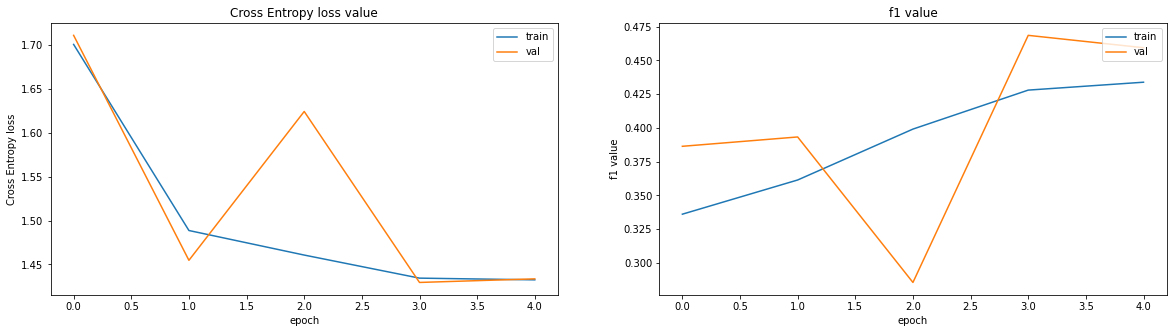

In [36]:
plot_results(losses, losses_eval, f1s, f1s_eval)

Без регуляризации обучилось до 0.65, посмотрим, что будет с регуляризацией:

In [37]:
model = CLSTM(len(train_dataset.word2id), 300, 150, [2], 150, 1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), weight_decay=0.001)
losses, losses_eval, f1s, f1s_eval = train_process(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   val_iterator)
experiments.append([False, 150, [2], 150, 1,'no', True, losses_eval[-1], f1s_eval[-1]])


starting Epoch 0
Training...
F-score: 0.34245073795318604, loss: 1.7768494153426866

Validating...
F-score: 0.29422900080680847, loss: 1.5386345744132996

starting Epoch 1
Training...
F-score: 0.43538445234298706, loss: 1.3970739942486003

Validating...
F-score: 0.6473584771156311, loss: 1.0807044208049774

starting Epoch 2
Training...
F-score: 0.6449501514434814, loss: 0.9929434970273809

Validating...
F-score: 0.6613957285881042, loss: 0.836103081703186

starting Epoch 3
Training...
F-score: 0.6579094529151917, loss: 0.832200424145844

Validating...
F-score: 0.6714347004890442, loss: 0.7942691415548324

starting Epoch 4
Training...
F-score: 0.66666579246521, loss: 0.8289850495629392

Validating...
F-score: 0.38736221194267273, loss: 1.4105225861072541


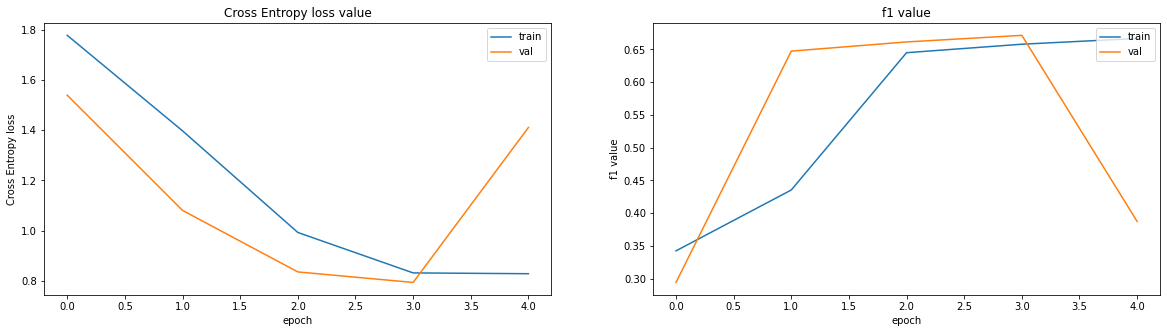

In [38]:
plot_results(losses, losses_eval, f1s, f1s_eval)

Эта модель обучилась лучше, посмотрим, что будет, если обучать на предобученных весах:

In [39]:
model = CLSTM(len(word2id), 300, 150, [2], 150, 1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), weight_decay=0.001)
losses, losses_eval, f1s, f1s_eval = train_process(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   val_iterator)
experiments.append([True, 150, [2], 150, 1, 'no', True, losses_eval[-1], f1s_eval[-1]])


starting Epoch 0
Training...
F-score: 0.4246886670589447, loss: 1.6571857191748538

Validating...
F-score: 0.60297030210495, loss: 0.9872476577758789

starting Epoch 1
Training...
F-score: 0.6373764276504517, loss: 0.9847942732148252

Validating...
F-score: 0.6384940147399902, loss: 0.9851448446512222

starting Epoch 2
Training...
F-score: 0.6782355308532715, loss: 0.7933422741243394

Validating...
F-score: 0.69210284948349, loss: 0.7435182809829712

starting Epoch 3
Training...
F-score: 0.6936928033828735, loss: 0.7480990219924409

Validating...
F-score: 0.6776120066642761, loss: 0.7211473226547241

starting Epoch 4
Training...
F-score: 0.7040770649909973, loss: 0.7350923348281343

Validating...
F-score: 0.6884471774101257, loss: 0.718826299905777


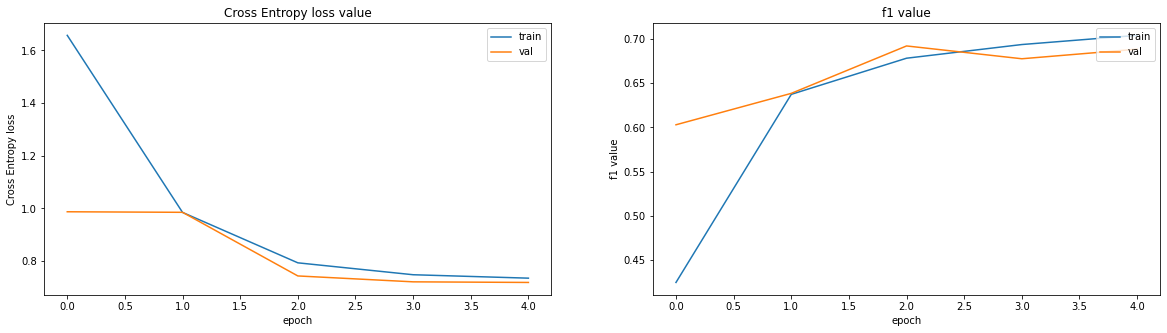

In [40]:
plot_results(losses, losses_eval, f1s, f1s_eval)

Модель с предобученными весами и регуляризацией обучилась лучше всех, будет использовать ее дальше. Теперь добавим еще один уровень сверток:

In [41]:
model = CLSTM(len(word2id), 300, 150, [2, 3], 150, 1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=0.001)
losses, losses_eval, f1s, f1s_eval = train_process(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   val_iterator)
experiments.append([True, 150, [2, 3], 150, 1, 'no', True, losses_eval[-1], f1s_eval[-1]])


starting Epoch 0
Training...
F-score: 0.39186403155326843, loss: 1.6183332790762692

Validating...
F-score: 0.39543336629867554, loss: 1.543198013305664

starting Epoch 1
Training...
F-score: 0.40829285979270935, loss: 1.5015241917917284

Validating...
F-score: 0.39068037271499634, loss: 1.4860661625862122

starting Epoch 2
Training...
F-score: 0.4078671336174011, loss: 1.4627058142322604

Validating...
F-score: 0.3985811471939087, loss: 1.4603103041648864

starting Epoch 3
Training...
F-score: 0.4065839946269989, loss: 1.4476334321296822

Validating...
F-score: 0.39276134967803955, loss: 1.4497979700565338

starting Epoch 4
Training...
F-score: 0.40658989548683167, loss: 1.4405184721542617

Validating...
F-score: 0.39661335945129395, loss: 1.4422145068645478


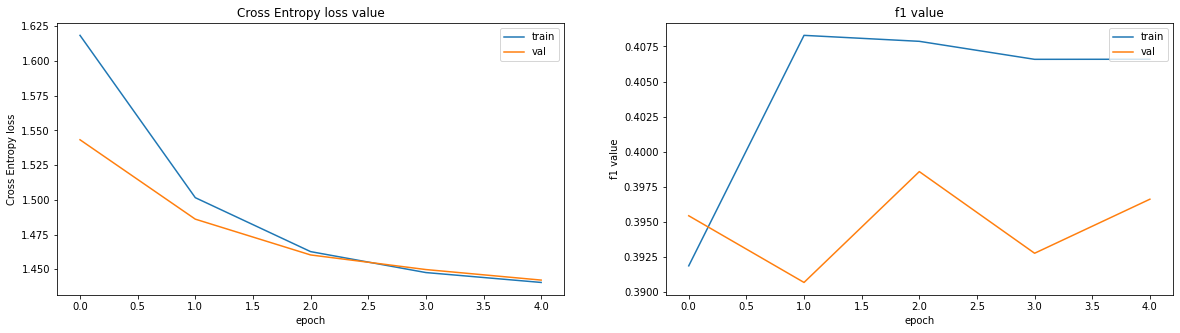

In [42]:
plot_results(losses, losses_eval, f1s, f1s_eval)

С двумя слоями работает хуже, чем с одним. По графику похоже, что она переобучается. Попробуем исправить это дропаутом:

In [43]:
model = CLSTM(len(word2id), 300, 150, [2, 3], 150, 1, dropout='after', dropout_per=0.5, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=0.001)
losses, losses_eval, f1s, f1s_eval = train_process(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   val_iterator)
experiments.append([False, 150, [2, 3], 150, 1, 'after', True, losses_eval[-1], f1s_eval[-1]])


starting Epoch 0
Training...
F-score: 0.38269108533859253, loss: 1.671048659389302

Validating...
F-score: 0.3884072005748749, loss: 1.5768649935722352

starting Epoch 1
Training...
F-score: 0.3969006836414337, loss: 1.5281207399853205

Validating...
F-score: 0.38637876510620117, loss: 1.5010125577449798

starting Epoch 2
Training...
F-score: 0.39659759402275085, loss: 1.4756938158455541

Validating...
F-score: 0.38578587770462036, loss: 1.4691112518310547

starting Epoch 3
Training...
F-score: 0.3971409201622009, loss: 1.454643801107245

Validating...
F-score: 0.3838631808757782, loss: 1.4565164268016815

starting Epoch 4
Training...
F-score: 0.3998779356479645, loss: 1.4453211901551586

Validating...
F-score: 0.38496705889701843, loss: 1.444743126630783


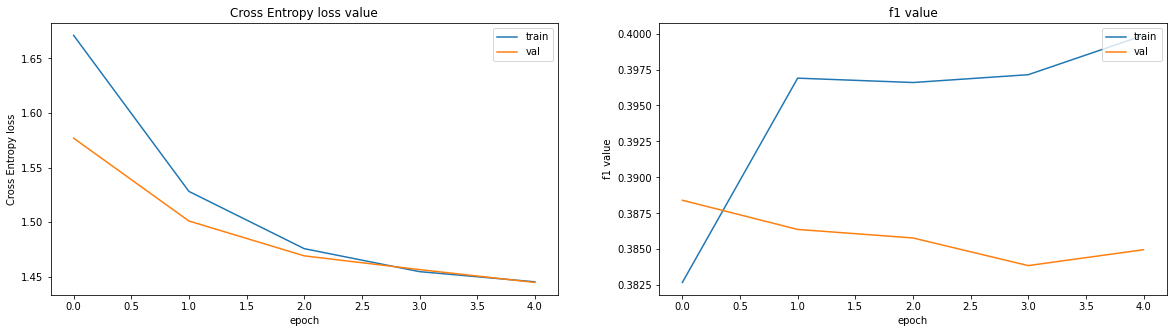

In [44]:
plot_results(losses, losses_eval, f1s, f1s_eval)

Не помогло! Попробуем дропаут в начале (как в статье):

In [45]:
model = CLSTM(len(word2id), 300, 150, [2, 3], 150, 1, dropout='before', dropout_per=0.5, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=0.001)
losses, losses_eval, f1s, f1s_eval = train_process(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   val_iterator)
experiments.append([True, 150, [2, 3], 150, 1, 'before', True, losses_eval[-1], f1s_eval[-1]])


starting Epoch 0
Training...
F-score: 0.3929949700832367, loss: 1.5617776482792225

Validating...
F-score: 0.3903086185455322, loss: 1.4921200752258301

starting Epoch 1
Training...
F-score: 0.40244191884994507, loss: 1.465808858305721

Validating...
F-score: 0.39077484607696533, loss: 1.4564669907093049

starting Epoch 2
Training...
F-score: 0.4056203067302704, loss: 1.4465248180648027

Validating...
F-score: 0.3895461857318878, loss: 1.4570127546787262

starting Epoch 3
Training...
F-score: 0.40642601251602173, loss: 1.4387906062400948

Validating...
F-score: 0.3958407938480377, loss: 1.4399852693080901

starting Epoch 4
Training...
F-score: 0.40853622555732727, loss: 1.4367849826812744

Validating...
F-score: 0.39540573954582214, loss: 1.4385343849658967


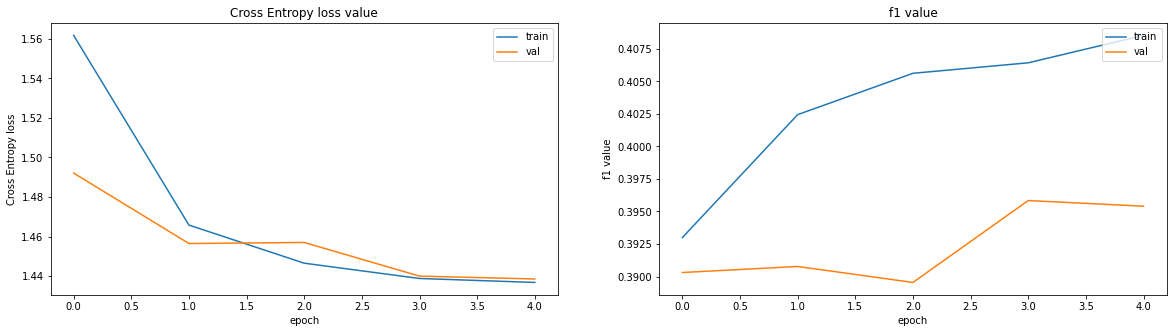

In [46]:
plot_results(losses, losses_eval, f1s, f1s_eval)

Не помогло. Возможно, стоит попробовать с одним слоем, но теперь с фильтром 3:

In [47]:
model = CLSTM(len(word2id), 300, 150, [3], 150, 1, dropout='after', dropout_per=0.5, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=0.001)
losses, losses_eval, f1s, f1s_eval = train_process(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   val_iterator)
experiments.append([True, 150, [3], 150, 1, 'after', True, losses_eval[-1], f1s_eval[-1]])


starting Epoch 0
Training...
F-score: 0.33662790060043335, loss: 1.6697647793818329

Validating...
F-score: 0.38753023743629456, loss: 1.5887924075126647

starting Epoch 1
Training...
F-score: 0.40336278080940247, loss: 1.5401595305588285

Validating...
F-score: 0.3908770978450775, loss: 1.5070650398731231

starting Epoch 2
Training...
F-score: 0.40420421957969666, loss: 1.4817080396716877

Validating...
F-score: 0.3878495395183563, loss: 1.4721490919589997

starting Epoch 3
Training...
F-score: 0.4048903286457062, loss: 1.455128382828276

Validating...
F-score: 0.3910714089870453, loss: 1.4524576306343078

starting Epoch 4
Training...
F-score: 0.4049147367477417, loss: 1.4456271822169675

Validating...
F-score: 0.3921302855014801, loss: 1.4468485057353973


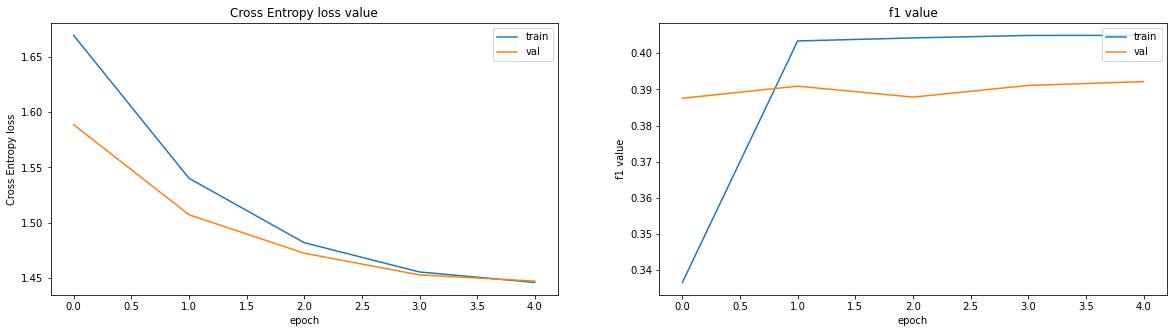

In [48]:
plot_results(losses, losses_eval, f1s, f1s_eval)

Попробуем без дропаута и с прежним learning rate и 2 слоями LSTM:

In [49]:
model = CLSTM(len(word2id), 300, 150, [3], 150, 2, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), weight_decay=0.001)
losses, losses_eval, f1s, f1s_eval = train_process(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   val_iterator)
experiments.append([True, 150, [3], 150, 2, 'no', True, losses_eval[-1], f1s_eval[-1]])


starting Epoch 0
Training...
F-score: 0.34131795167922974, loss: 1.7505670199959964

Validating...
F-score: 0.28836166858673096, loss: 1.471134638786316

starting Epoch 1
Training...
F-score: 0.397710382938385, loss: 1.4491805747403936

Validating...
F-score: 0.29232022166252136, loss: 1.4535758912563324

starting Epoch 2
Training...
F-score: 0.402917742729187, loss: 1.4503084865667053

Validating...
F-score: 0.39378640055656433, loss: 1.4412526488304138

starting Epoch 3
Training...
F-score: 0.39664843678474426, loss: 1.441528679960865

Validating...
F-score: 0.39265331625938416, loss: 1.4754342794418336

starting Epoch 4
Training...
F-score: 0.4050282835960388, loss: 1.4426296585697238

Validating...
F-score: 0.393042653799057, loss: 1.4506000697612762


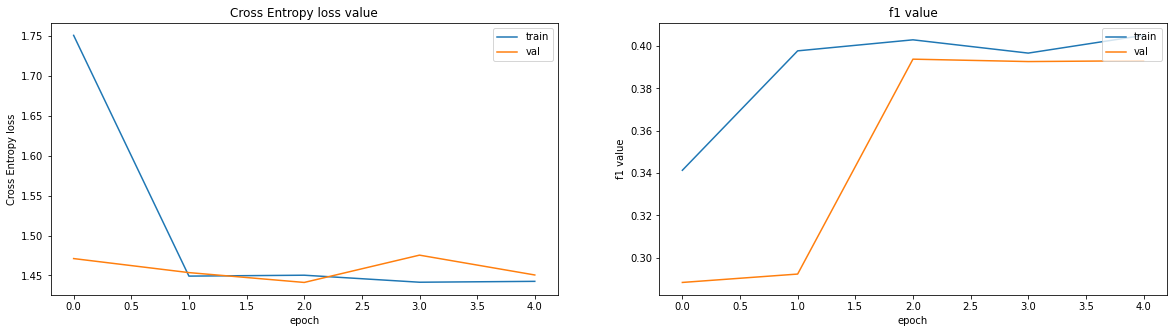

In [50]:
plot_results(losses, losses_eval, f1s, f1s_eval)

Так тоже не сработало! Попробуем чуть уменьшить learning rate:

In [51]:
model = CLSTM(len(word2id), 300, 150, [2, 3], 150, 1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.001)
losses, losses_eval, f1s, f1s_eval = train_process(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   val_iterator)
experiments.append([True, 150, [2, 3], 150, 1, 'no', True, losses_eval[-1], f1s_eval[-1]])


starting Epoch 0
Training...
F-score: 0.395802766084671, loss: 1.4556838193182218

Validating...
F-score: 0.39696115255355835, loss: 1.4252041101455688

starting Epoch 1
Training...
F-score: 0.40313515067100525, loss: 1.4336664919125832

Validating...
F-score: 0.40052834153175354, loss: 1.4321730792522431

starting Epoch 2
Training...
F-score: 0.4218348562717438, loss: 1.4108186495506156

Validating...
F-score: 0.398948073387146, loss: 1.4261880934238433

starting Epoch 3
Training...
F-score: 0.42678138613700867, loss: 1.3935861143015198

Validating...
F-score: 0.4006993770599365, loss: 1.4294010043144225

starting Epoch 4
Training...
F-score: 0.4334750771522522, loss: 1.3808331509767953

Validating...
F-score: 0.4014742374420166, loss: 1.4429047226905822


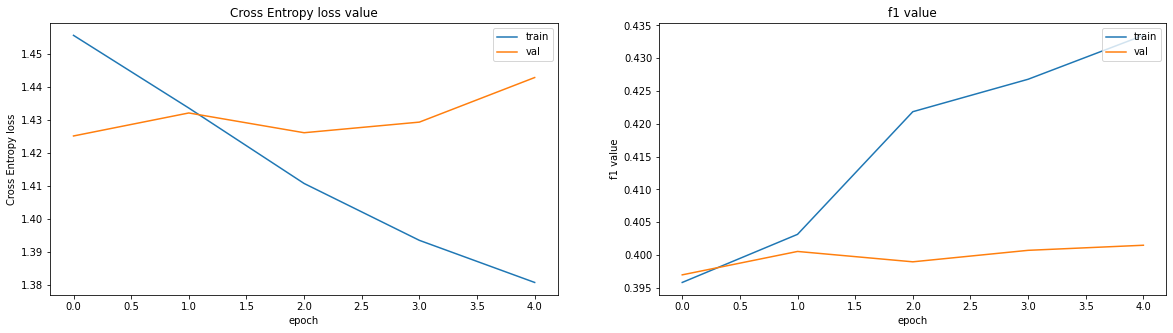

In [52]:
plot_results(losses, losses_eval, f1s, f1s_eval)

Попробуем с тремя сверточными слоями: 

In [53]:
model = CLSTM(len(word2id), 300, 150, [2, 3, 4], 150, 1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=0.01)
losses, losses_eval, f1s, f1s_eval = train_process(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   val_iterator)
experiments.append([True, 150, [2, 3, 4], 150, 1, 'no', True, losses_eval[-1], f1s_eval[-1]])


starting Epoch 0
Training...
F-score: 0.4015491306781769, loss: 1.4499670186285245

Validating...
F-score: 0.39375412464141846, loss: 1.4336041808128357

starting Epoch 1
Training...
F-score: 0.40570828318595886, loss: 1.4373812897730682

Validating...
F-score: 0.39513152837753296, loss: 1.4335489571094513

starting Epoch 2
Training...
F-score: 0.40808627009391785, loss: 1.4327134318270927

Validating...
F-score: 0.39427515864372253, loss: 1.4405222952365875

starting Epoch 3
Training...
F-score: 0.4080030620098114, loss: 1.4340787459228

Validating...
F-score: 0.39402446150779724, loss: 1.432565873861313

starting Epoch 4
Training...
F-score: 0.4076448082923889, loss: 1.4337701474205922

Validating...
F-score: 0.3950343430042267, loss: 1.4403288125991822


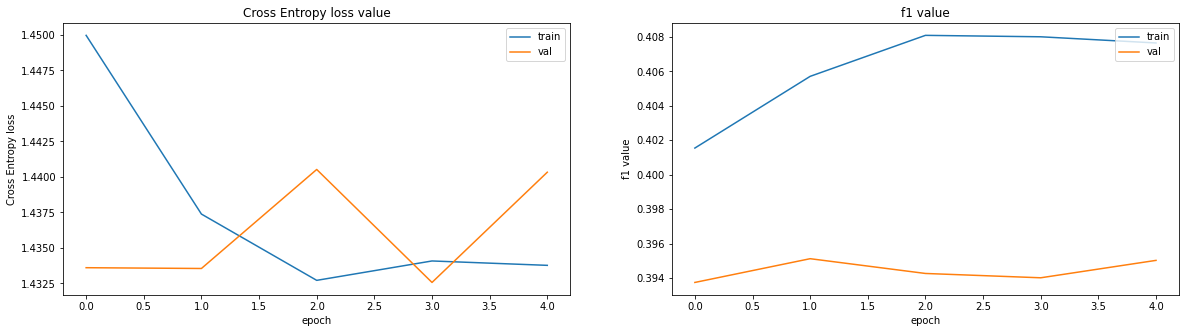

In [54]:
plot_results(losses, losses_eval, f1s, f1s_eval)

Упс, эта модель не обучилась...

Теперь попробуем с одним, но размерностью 4: 

In [55]:
model = CLSTM(len(word2id), 300, 150, [4], 150, 1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=0.0001)
losses, losses_eval, f1s, f1s_eval = train_process(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   val_iterator)
experiments.append([True, 150, [4], 150, 1, 'no', True, losses_eval[-1], f1s_eval[-1]])


starting Epoch 0
Training...
F-score: 0.39738425612449646, loss: 1.4517017764560247

Validating...
F-score: 0.3940524756908417, loss: 1.4429243326187133

starting Epoch 1
Training...
F-score: 0.411645770072937, loss: 1.432697528499668

Validating...
F-score: 0.38941311836242676, loss: 1.4361099362373353

starting Epoch 2
Training...
F-score: 0.4146815836429596, loss: 1.429349660873413

Validating...
F-score: 0.39408931136131287, loss: 1.4336595952510833

starting Epoch 3
Training...
F-score: 0.4162037670612335, loss: 1.4262784234548018

Validating...
F-score: 0.39156433939933777, loss: 1.4304721415042878

starting Epoch 4
Training...
F-score: 0.4176507294178009, loss: 1.4234520217119637

Validating...
F-score: 0.3947189748287201, loss: 1.4326884865760803


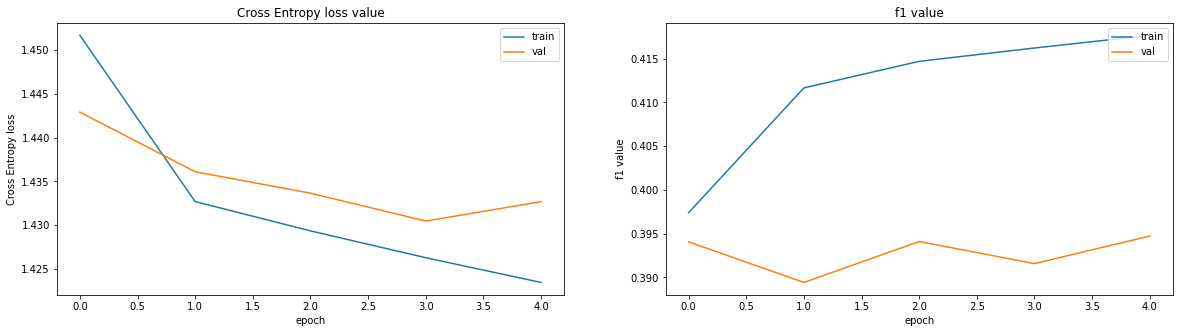

In [56]:
plot_results(losses, losses_eval, f1s, f1s_eval)

Попробуем уменьшить размерности:

In [57]:
model = CLSTM(len(word2id), 300, 100, [2], 100, 1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=0.01)
losses, losses_eval, f1s, f1s_eval = train_process(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   val_iterator)
experiments.append([True, 100, [2], 100, 1, 'no', True, losses_eval[-1], f1s_eval[-1]])


starting Epoch 0
Training...
F-score: 0.40064871311187744, loss: 1.4748139058129262

Validating...
F-score: 0.39130720496177673, loss: 1.442094475030899

starting Epoch 1
Training...
F-score: 0.40912318229675293, loss: 1.4378197779089719

Validating...
F-score: 0.3963983654975891, loss: 1.4402541160583495

starting Epoch 2
Training...
F-score: 0.41024157404899597, loss: 1.4356674642886145

Validating...
F-score: 0.39076337218284607, loss: 1.4402112782001495

starting Epoch 3
Training...
F-score: 0.40826842188835144, loss: 1.4349274837364585

Validating...
F-score: 0.3937956690788269, loss: 1.4375840604305268

starting Epoch 4
Training...
F-score: 0.40984201431274414, loss: 1.436455007326805

Validating...
F-score: 0.3923175036907196, loss: 1.438941490650177


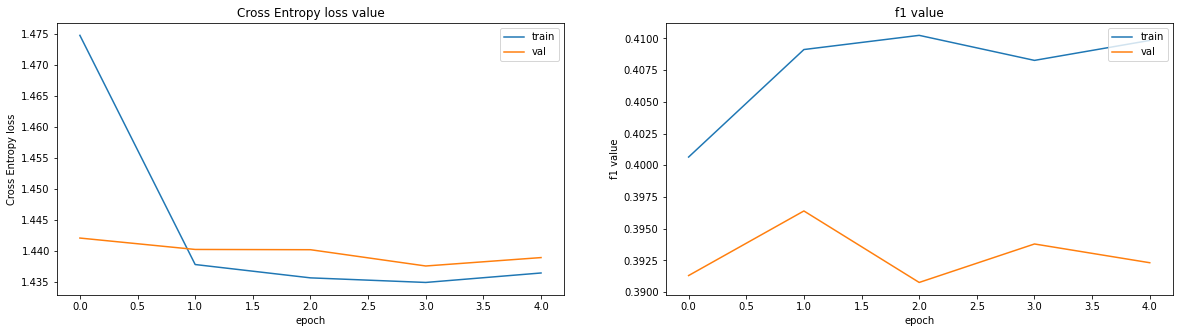

In [58]:
plot_results(losses, losses_eval, f1s, f1s_eval)

Попробуем увеличить с лучшим результатом:

In [59]:
model = CLSTM(len(word2id), 300, 300, [2], 300, 1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), weight_decay=0.001)
losses, losses_eval, f1s, f1s_eval = train_process(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   val_iterator)
experiments.append([True, 300, [2], 300, 1, 'no', True, losses_eval[-1], f1s_eval[-1]])


starting Epoch 0
Training...
F-score: 0.3054313659667969, loss: 2.2063801672499057

Validating...
F-score: 0.38934096693992615, loss: 1.4937391936779023

starting Epoch 1
Training...
F-score: 0.37799307703971863, loss: 1.4823817135924

Validating...
F-score: 0.39502662420272827, loss: 1.4433539390563965

starting Epoch 2
Training...
F-score: 0.3936660587787628, loss: 1.4485861729767362

Validating...
F-score: 0.38325613737106323, loss: 1.4514262676239014

starting Epoch 3
Training...
F-score: 0.39674392342567444, loss: 1.4496025614819283

Validating...
F-score: 0.3925165832042694, loss: 1.5275041937828064

starting Epoch 4
Training...
F-score: 0.3973199129104614, loss: 1.4486901881331105

Validating...
F-score: 0.29398414492607117, loss: 1.498790442943573


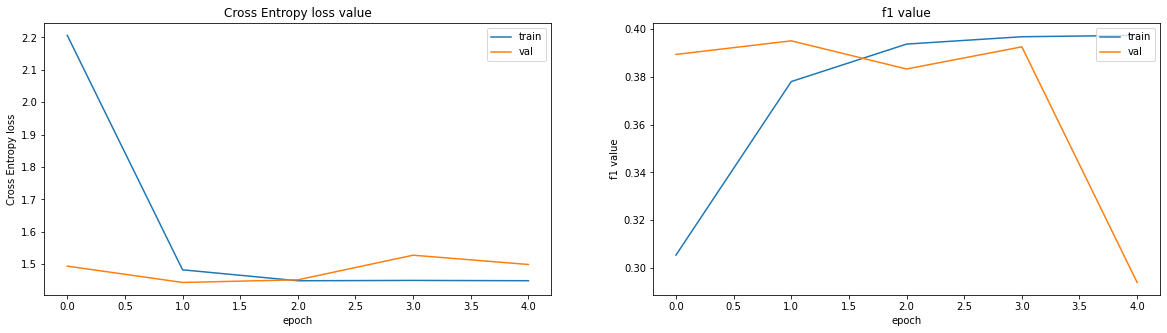

In [60]:
plot_results(losses, losses_eval, f1s, f1s_eval)

In [61]:
model = CLSTM(len(word2id), 300, 300, [2], 300, 2, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), weight_decay=0.001)
losses, losses_eval, f1s, f1s_eval = train_process(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   val_iterator)
experiments.append([True, 300, [2], 300, 2, 'no', True, losses_eval[-1], f1s_eval[-1]])


starting Epoch 0
Training...
F-score: 0.29827216267585754, loss: 3.3119546740742054

Validating...
F-score: 0.39026451110839844, loss: 1.4688195407390594

starting Epoch 1
Training...
F-score: 0.357591450214386, loss: 1.6109687453609403

Validating...
F-score: 0.28961262106895447, loss: 1.5000285506248474

starting Epoch 2
Training...
F-score: 0.3906290829181671, loss: 1.4609855211387246

Validating...
F-score: 0.3873036801815033, loss: 1.4740901648998261

starting Epoch 3
Training...
F-score: 0.36373770236968994, loss: 1.5839657561253693

Validating...
F-score: 0.28914594650268555, loss: 1.453746074438095

starting Epoch 4
Training...
F-score: 0.3807511031627655, loss: 1.4716401180978549

Validating...
F-score: 0.3953697085380554, loss: 1.462989377975464


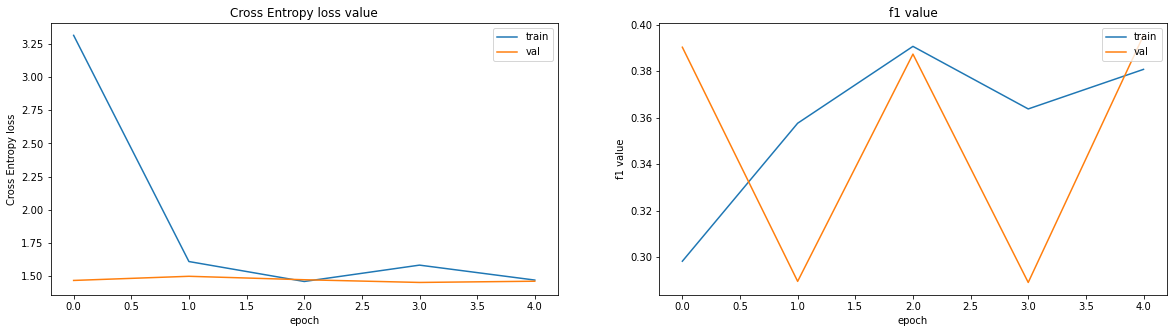

In [62]:
plot_results(losses, losses_eval, f1s, f1s_eval)

### Оценка экспериментов

Мы экспериментировали с несколькими параметрами. В таблице мы представили только интерпретируемые (lr не очень интерпретируется как-либо, его можно только угадать). 
В первую очередь мы экспериментировали с регуляризациями и дропаутами, размерами скрытых слоев и их количеством и размерами фильтров на свертках.

In [63]:
experiments_df = pd.DataFrame(experiments)

In [64]:
experiments_df.columns = experiments_df.iloc[0]
experiments_df = experiments_df[1:]

In [65]:
experiments_df['f1'] = experiments_df['f1'].apply(lambda x: x.cpu().detach().numpy())

In [66]:
experiments_df

,pretrained,filter_number,filter_size,hidden_size,num_layers,dropout,weight_decay,loss,f1
1,False,150,[2],150,1,no,False,1.43353,0.459462
2,False,150,[2],150,1,no,True,1.41052,0.387362
3,True,150,[2],150,1,no,True,0.718826,0.688447
4,True,150,"[2, 3]",150,1,no,True,1.44221,0.396613
5,False,150,"[2, 3]",150,1,after,True,1.44474,0.384967
6,True,150,"[2, 3]",150,1,before,True,1.43853,0.395406
7,True,150,[3],150,1,after,True,1.44685,0.392130
8,True,150,[3],150,2,no,True,1.4506,0.393043
9,True,150,"[2, 3]",150,1,no,True,1.4429,0.401474
10,True,150,"[2, 3, 4]",150,1,no,True,1.44033,0.395034


Как мы видим, лучшее качество с одним слоем сверток и фильтром 2 и размерностью эмбеддингов и скрытых слоев 150. 

### Результаты

Теперь попробуем проанализировать наши результаты. Как и в статье, на наших данных одиночный сверточный слой работал лучше, чем несколько сверточных слоев. Вероятно, несколько слоев ведут к переобучению, так как слишком много информации о тексте. 

Регуляризация помогла, а дропаут оказался скорее бесполезным (в отличие от оригинальной статьи).

Кроме этого, в нашем случае лучшим размером фильтра оказался 2, вероятно, все устойчивые коллокации, различающие тематики, были биграммами. 

Интересно, что предобученные вектора увеличили скор, но не так сильно! Вероятно, многих слов просто не было в модели, так как датасет взят из твиттера, где много хэштегов, сокращений и сленга.

Модель с одним слоем показала себя лучше, чем модель с двумя. В целом информации оказывается столько, что одного досаточно (хотя может быть и нет, потому что качество далеко от идеального).

Последнее, с чем мы экспериментировали, - это скрытые слои. Оказалось, что 300 работает хуже, чем 150 при хорошей комбинации остальных параметров. Вероятно, при меньшем эмбеддинге лучше сжимается нужная информация.



### Ячейки RNN, LSTM и GRU

In [67]:
class RNNCell(nn.Module):
    def __init__(self, input, hidden):
        super().__init__()
        self.input = input
        self.hidden = hidden
        self.W_i = torch.randn(self.input, self.hidden)
        self.W_h = torch.randn(self.hidden, self.hidden)
        self.b = torch.zeros(1, hidden)
        self.tanh = nn.Tanh()

    def forward(self, x, h):
        h = self.tanh(x @ self.W_i + self.b + h @ self.W_h + self.b)
        return h

Проверим:

In [68]:
rnn = RNNCell(3, 5)
x = torch.tensor([[0,1,2], [3,4,5], 
    [6,7,8], [9,0,1]], dtype = torch.float)
h = torch.randn(1, 5)
output = rnn(x, h)

In [69]:
class LSTMCell(nn.Module):
    def __init__(self, input, hidden):
        super().__init__()
        self.input = input
        self.hidden = hidden
        self.W_i = torch.randn(self.input, self.hidden)
        self.W_h = torch.randn(self.hidden, self.hidden)
        self.b = torch.zeros(1, hidden)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x, h, c):
        i = self.sigmoid(x @ self.W_i + self.b + h @ self.W_h + self.b)
        f = self.sigmoid(x @ self.W_i + self.b +  h @ self.W_h + self.b)
        g = self.tanh(x @ self.W_i + self.b +  h @ self.W_h + self.b)
        o = self.sigmoid(x @ self.W_i + self.b + h @ self.W_h + self.b)
        c = c * f + i * g
        h = self.tanh(c) * o
        return h, c

In [70]:
lstm = LSTMCell(3, 5)
x = torch.tensor([[0,1,2], [3,4,5], 
    [6,7,8], [9,0,1]], dtype = torch.float)
h = torch.randn(1, 5)
c = torch.randn(1, 5)
h, c = lstm(x, h, c)

Проверим:

In [71]:
class GRUCell(nn.Module):
    def __init__(self, input, hidden):
        super().__init__()
        self.input = input
        self.hidden = hidden
        self.W_i = torch.randn(self.input, self.hidden)
        self.W_h = torch.randn(self.hidden, self.hidden)
        self.b = torch.zeros(1, self.hidden)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()


    def forward(self, x, h):
        r = self.sigmoid(x @ self.W_i + self.b +  h @ self.W_h + self.b)
        z = self.sigmoid(x @ self.W_i + self.b +  h @ self.W_h + self.b) 
        n = self.tanh(x @ self.W_i + self.b + r * ( h @ self.W_h + self.b))
        h = (1 - z) * n + z * h
        return h 

Проверим:

In [72]:
gru = GRUCell(3, 5)
x = torch.tensor([[0,1,2], [3,4,5], 
    [6,7,8], [9,0,1]], dtype = torch.float)
h = torch.randn(1, 5)
h = gru(x, h)

In [73]:
class RNNLayer(nn.Module):
    def __init__(self, input, hidden, batch_size, layer):
        super().__init__()
        self.input = input
        self.hidden = hidden
        self.batch_size = batch_size
        self.layer = layer
        self.rnncell = RNNCell(self.input, self.hidden)
        self.lstmcell = LSTMCell(self.input, self.hidden)
        self.grucell = GRUCell(self.input, self.hidden)
        self.h = torch.randn(self.batch_size, self.hidden)
        self.c = torch.randn(self.batch_size, self.hidden) # for LSTMCell

    def forward(self, X):
        out = []
        for i in range(len(X)):
          if self.layer == 'rnn':
              self.h = self.rnncell(X[i], self.h)
              h = self.h
          elif self.layer == 'lstm':
              self.h, self.c = self.lstmcell(X[i], self.h, self.c)
              h = (self.h, self.c)
          elif self.layer == 'gru':
              self.h = self.lstmcell(X[i], self.h)
              h = self.h
          out.append(self.h)  
        
        return out, h

Посмотрим, работает ли слой:

In [74]:
BATCH_SIZE = 4 
INPUT = 3
HIDDEN = 5

X_batch = torch.tensor([[[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float)

model = RNNLayer(INPUT, HIDDEN, BATCH_SIZE, layer='rnn')
output, hidden = model(X_batch)